In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import seaborn as sns
import networkx as nx

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

# 1. Preparing the dataset

The following data are from S&P 100, from January 2014 to December 2022.


The S&P 100, also known as the Standard & Poor's 100, is a stock market index comprised of the largest and most established companies in the United States. These companies represent a diverse array of sectors such as technology, finance, healthcare, and consumer goods. Companies included in the S&P 100 are typically leaders in their respective industries, making the index a reflection of the stability and strength of the U.S. economy.

In [2]:
sp100 = pd.read_csv('/Users/sabrina.aufiero/Desktop/COMP0050 Machine Learning with Applications in Finance/Data_Lecture5/sp100.csv')
display(sp100)

,ticker,name,sector,permno,mention
0,AAPL,Apple,Information Technology,14593.0,"@apple, @iphone"
1,ABBV,AbbVie,Health Care,13721.0,@abbvie
2,ABT,Abbott,Health Care,20482.0,@AbbottNews
3,ACN,Accenture,Information Technology,89071.0,@Accenture
4,ADBE,Adobe,Information Technology,75510.0,@Adobe
...,...,...,...,...,...
96,VZ,Verizon,Communication Services,65875.0,@Verizon
97,WBA,Walgreens Boots Alliance,Consumer Staples,19502.0,@WBA_Global
98,WFC,Wells Fargo,Financials,38703.0,"@WellsFargo, @Ask_WellsFargo"
99,WMT,Walmart,Consumer Staples,55976.0,@Walmart


In [3]:
stock_returns = pd.read_csv('/Users/sabrina.aufiero/Desktop/COMP0050 Machine Learning with Applications in Finance/Data_Lecture5/filtered_stock_returns.csv')
display(stock_returns)

,date,permno,prc
0,2014-01-02,14593.0,553.130005
1,2014-01-03,14593.0,540.979980
2,2014-01-06,14593.0,543.929993
3,2014-01-07,14593.0,540.037476
4,2014-01-08,14593.0,543.460022
...,...,...,...
221004,2022-12-23,11850.0,108.680000
221005,2022-12-27,11850.0,110.190002
221006,2022-12-28,11850.0,108.379997
221007,2022-12-29,11850.0,109.199997


In [4]:
# Merge the two DataFrames on the 'permno' column
detailed_stock_returns = pd.merge(stock_returns, sp100[['permno', 'ticker', 'name', 'sector']], on='permno', how='left')

# Display the head of the merged DataFrame
display(detailed_stock_returns)

,date,permno,prc,ticker,name,sector
0,2014-01-02,14593.0,553.130005,AAPL,Apple,Information Technology
1,2014-01-03,14593.0,540.979980,AAPL,Apple,Information Technology
2,2014-01-06,14593.0,543.929993,AAPL,Apple,Information Technology
3,2014-01-07,14593.0,540.037476,AAPL,Apple,Information Technology
4,2014-01-08,14593.0,543.460022,AAPL,Apple,Information Technology
...,...,...,...,...,...,...
221004,2022-12-23,11850.0,108.680000,XOM,ExxonMobil,Energy
221005,2022-12-27,11850.0,110.190002,XOM,ExxonMobil,Energy
221006,2022-12-28,11850.0,108.379997,XOM,ExxonMobil,Energy
221007,2022-12-29,11850.0,109.199997,XOM,ExxonMobil,Energy


In [5]:
# Find the initial and final dates
initial_date = detailed_stock_returns['date'].min()
final_date = detailed_stock_returns['date'].max()
print(f"Initial date: {initial_date}, Final date: {final_date}")

# Check if all companies have data spanning the same date range
date_range_per_company = detailed_stock_returns.groupby('name')['date'].agg(['min', 'max'])
print(f"Date range per company:\n{date_range_per_company}")

# Check if all companies have the same initial and final dates
same_date_range_for_all = (date_range_per_company['min'] == initial_date).all() and (date_range_per_company['max'] == final_date).all()
print(f"All companies have data spanning the same date range: {same_date_range_for_all}")

Initial date: 2014-01-02, Final date: 2022-12-30
Date range per company:
                                 min         max
name                                            
3M                        2014-01-02  2022-12-30
AT&T                      2014-01-02  2022-12-30
AbbVie                    2014-01-02  2022-12-30
Abbott                    2014-01-02  2022-12-30
Accenture                 2014-01-02  2022-12-30
...                              ...         ...
Verizon                   2014-01-02  2022-12-30
Visa                      2014-01-02  2022-12-30
Walgreens Boots Alliance  2014-01-02  2022-12-30
Walmart                   2014-01-02  2022-12-30
Wells Fargo               2014-01-02  2022-12-30

[99 rows x 2 columns]
All companies have data spanning the same date range: False


In [6]:
# Filter companies that don't have the minimum date as '2014-01-02'
companies_not_starting_on_min_date = date_range_per_company[date_range_per_company['min'] != '2014-01-02']

# Print the names of these companies
print(companies_not_starting_on_min_date.index.tolist())

['Kraft Heinz', 'Linde', 'PayPal']


In [7]:
# Filter companies that don't have the maximum date as '2022-12-30'
companies_not_ending_on_max_date = date_range_per_company[date_range_per_company['max'] != '2022-12-30']

# Print the names of these companies
print(companies_not_ending_on_max_date.index.tolist())

['Dow']


In [8]:
# Remove the specified companies from detailed_stock_returns
companies_to_remove = ['Kraft Heinz', 'Linde', 'PayPal', 'Dow']
filtered_detailed_stock_returns = detailed_stock_returns[~detailed_stock_returns['name'].isin(companies_to_remove)]

# Save the filtered data to a new CSV file, if necessary
filtered_detailed_stock_returns.to_csv('filtered_detailed_stock_returns.csv', index=False)

display(filtered_detailed_stock_returns)

,date,permno,prc,ticker,name,sector
0,2014-01-02,14593.0,553.130005,AAPL,Apple,Information Technology
1,2014-01-03,14593.0,540.979980,AAPL,Apple,Information Technology
2,2014-01-06,14593.0,543.929993,AAPL,Apple,Information Technology
3,2014-01-07,14593.0,540.037476,AAPL,Apple,Information Technology
4,2014-01-08,14593.0,543.460022,AAPL,Apple,Information Technology
...,...,...,...,...,...,...
221004,2022-12-23,11850.0,108.680000,XOM,ExxonMobil,Energy
221005,2022-12-27,11850.0,110.190002,XOM,ExxonMobil,Energy
221006,2022-12-28,11850.0,108.379997,XOM,ExxonMobil,Energy
221007,2022-12-29,11850.0,109.199997,XOM,ExxonMobil,Energy


In [9]:
# Check the unique number of companies ('name'), sectors, and the count of names within each sector

num_companies = filtered_detailed_stock_returns['name'].nunique()
num_sectors = filtered_detailed_stock_returns['sector'].nunique()
names_per_sector = filtered_detailed_stock_returns.groupby('sector')['name'].nunique()

print(f"Number of companies: {num_companies}")
print(f"Number of sectors: {num_sectors}")
print(f"Names per sector:\n{names_per_sector}")

Number of companies: 95
Number of sectors: 10
Names per sector:
sector
Communication Services     9
Consumer Discretionary    11
Consumer Staples          10
Energy                     3
Financials                14
Health Care               14
Industrials               12
Information Technology    16
Real Estate                2
Utilities                  4
Name: name, dtype: int64


In [10]:
print(filtered_detailed_stock_returns['name'].unique())

['Apple' 'AbbVie' 'Abbott' 'Accenture' 'Adobe'
 'American International Group' 'Advanced Micro Devices' 'Amgen'
 'American Tower' 'Amazon' 'Broadcom' 'American Express' 'Boeing'
 'Bank of America' 'BNY Mellon' 'Booking Holdings' 'BlackRock'
 'Bristol Myers Squibb' 'Citigroup' 'Caterpillar' 'Charter Communications'
 'Colgate-Palmolive' 'Comcast' 'Capital One' 'ConocoPhillips' 'Costco'
 'Salesforce' 'Cisco' 'CVS Health' 'Chevron' 'Danaher' 'Disney'
 'Duke Energy' 'Emerson' 'Exelon' 'Ford' 'FedEx' 'General Dynamics' 'GE'
 'Gilead' 'GM' 'Alphabet (Class A)' 'Goldman Sachs' 'Home Depot'
 'Honeywell' 'IBM' 'Intel' 'Johnson & Johnson' 'JPMorgan Chase'
 'Coca-Cola' 'Lilly' 'Lockheed Martin' "Lowe's" 'Mastercard' "McDonald's"
 'Mondelēz International' 'Medtronic' 'MetLife' 'Meta' '3M' 'Altria'
 'Merck' 'Morgan Stanley' 'Microsoft' 'NextEra Energy' 'Netflix' 'Nike'
 'Nvidia' 'Oracle' 'PepsiCo' 'Pfizer' 'Procter & Gamble'
 'Philip Morris International' 'Qualcomm' 'Raytheon Technologies'
 'Starbuc

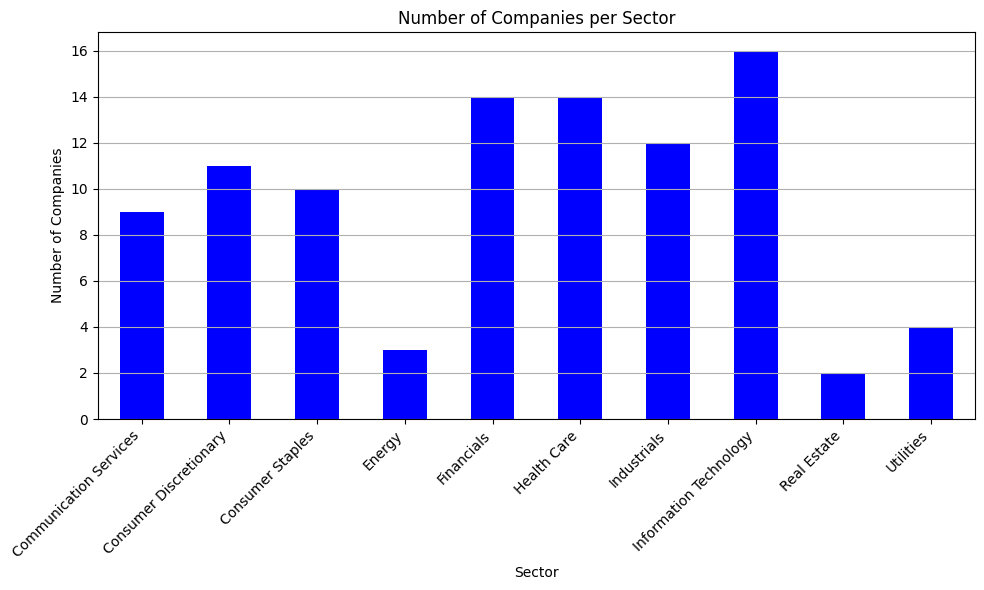

In [11]:
# Plotting the bar graph
plt.figure(figsize=(10, 6))
names_per_sector.plot(kind='bar', color='blue')
plt.grid(axis='y')
plt.title('Number of Companies per Sector')
plt.xlabel('Sector')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [12]:
#Convert the 'date' column to datetime format
filtered_detailed_stock_returns['date'] = pd.to_datetime(filtered_detailed_stock_returns['date'])

#Set the 'date' column as the index
filtered_detailed_stock_returns.set_index('date', inplace=True)

# Select one company per sector for plotting
unique_sectors = filtered_detailed_stock_returns['sector'].unique()
companies_to_plot = []
for sector in unique_sectors:
    first_company_in_sector = filtered_detailed_stock_returns[filtered_detailed_stock_returns['sector'] == sector]['name'].unique()[0]
    company_with_sector = f"{first_company_in_sector} - {sector}" 
    companies_to_plot.append(company_with_sector)

print(companies_to_plot)

['Apple - Information Technology', 'AbbVie - Health Care', 'American International Group - Financials', 'American Tower - Real Estate', 'Amazon - Consumer Discretionary', 'Boeing - Industrials', 'Charter Communications - Communication Services', 'Colgate-Palmolive - Consumer Staples', 'ConocoPhillips - Energy', 'Duke Energy - Utilities']


/var/folders/h9/ccpmv6014r170zs5rfn5dlgw0000gn/T/ipykernel_11641/4000309582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_detailed_stock_returns['date'] = pd.to_datetime(filtered_detailed_stock_returns['date'])


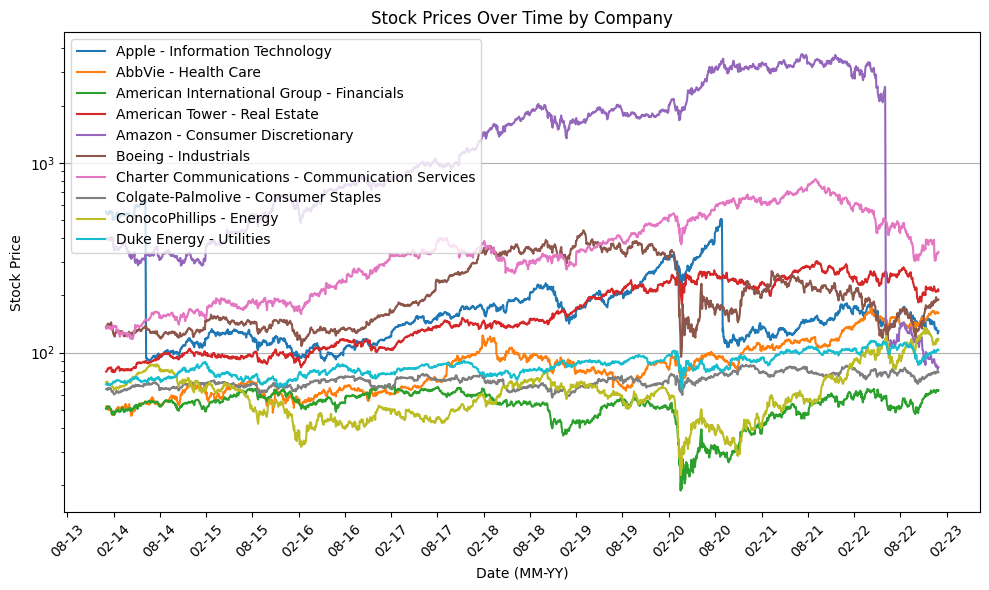

In [13]:
plt.figure(figsize=(10, 6))

for company_with_sector in companies_to_plot:
    # Split the company_with_sector string to extract the company name
    company_name = company_with_sector.split(" - ")[0]  # Extract the company name before " - "
    sector_name = company_with_sector.split(" - ")[1]  # Extract the sector name, if needed
    # Filter the data for this company
    company_data = filtered_detailed_stock_returns[filtered_detailed_stock_returns['name'] == company_name]

    plt.plot(company_data.index, company_data['prc'], label=company_with_sector) 

plt.yscale('log')
plt.title('Stock Prices Over Time by Company')
plt.xlabel('Date (MM-YY)')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=6))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [14]:
# Calculate returns for each company
filtered_detailed_stock_returns['return'] = filtered_detailed_stock_returns.groupby('name')['prc'].pct_change() 
                                                    #Fractional change between the current and the prior element

# Remove the first row for each company since it has no return data
detailed_stock_returns_with_return = filtered_detailed_stock_returns.dropna(subset=['return'])
display(detailed_stock_returns_with_return)

/var/folders/h9/ccpmv6014r170zs5rfn5dlgw0000gn/T/ipykernel_11641/1924583723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_detailed_stock_returns['return'] = filtered_detailed_stock_returns.groupby('name')['prc'].pct_change()


,permno,prc,ticker,name,sector,return
date,,,,,,
2014-01-03,14593.0,540.979980,AAPL,Apple,Information Technology,-0.021966
2014-01-06,14593.0,543.929993,AAPL,Apple,Information Technology,0.005453
2014-01-07,14593.0,540.037476,AAPL,Apple,Information Technology,-0.007156
2014-01-08,14593.0,543.460022,AAPL,Apple,Information Technology,0.006338
2014-01-09,14593.0,536.518982,AAPL,Apple,Information Technology,-0.012772
...,...,...,...,...,...,...
2022-12-23,11850.0,108.680000,XOM,ExxonMobil,Energy,0.026445
2022-12-27,11850.0,110.190002,XOM,ExxonMobil,Energy,0.013894
2022-12-28,11850.0,108.379997,XOM,ExxonMobil,Energy,-0.016426


We decide to keep, for each company, data from March 2014 to March 2020 (included).

In [15]:
# Define the start and end dates for the filtering
start_date = pd.to_datetime('2014-03-01')
end_date = pd.to_datetime('2020-03-31')

# Function to filter the dates for a given DataFrame
def filter_dates(df):
    return df[(df.index >= start_date) & (df.index <= end_date)]

# Apply the function to each company, maintaining the 'date' information
final_stock_returns = detailed_stock_returns_with_return.groupby('name', group_keys=False).apply(filter_dates)

display(final_stock_returns)

/var/folders/h9/ccpmv6014r170zs5rfn5dlgw0000gn/T/ipykernel_11641/3223042406.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_stock_returns = detailed_stock_returns_with_return.groupby('name', group_keys=False).apply(filter_dates)


,permno,prc,ticker,name,sector,return
date,,,,,,
2014-03-03,22592.0,132.210007,MMM,3M,Industrials,-0.018704
2014-03-04,22592.0,132.679993,MMM,3M,Industrials,0.003555
2014-03-05,22592.0,133.850006,MMM,3M,Industrials,0.008818
2014-03-06,22592.0,134.080002,MMM,3M,Industrials,0.001718
2014-03-07,22592.0,134.110001,MMM,3M,Industrials,0.000224
...,...,...,...,...,...,...
2020-03-25,38703.0,28.969999,WFC,Wells Fargo,Financials,0.001729
2020-03-26,38703.0,30.900000,WFC,Wells Fargo,Financials,0.066621
2020-03-27,38703.0,30.280001,WFC,Wells Fargo,Financials,-0.020065


In [16]:
print(final_stock_returns['name'].nunique())
print(final_stock_returns['sector'].nunique())

95
10


In [17]:
# Pivot the DataFrame to have dates as the index, companies as columns, and returns as values
returns = final_stock_returns.pivot_table(index='date', columns='ticker', values='return')

display(returns)

ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2014-03-03,0.002888,-0.016107,-0.011312,-0.010198,-0.011220,-0.006430,-0.010782,-0.002661,-0.000123,-0.006407,...,-0.002200,-0.004823,0.000104,-0.011910,-0.019917,-0.005675,-0.008094,-0.005816,-0.007764,-0.007998
2014-03-04,0.006594,0.029946,0.020086,0.017939,0.010905,0.016178,0.008174,0.018676,0.000982,0.011451,...,0.013359,0.024177,0.012529,0.018942,0.018335,0.012471,0.025074,0.012784,0.013626,0.010681
2014-03-05,0.002108,0.002132,-0.008225,0.001548,0.004373,0.012736,0.002703,0.001508,-0.009075,0.023276,...,-0.001792,0.002665,0.001031,0.000483,-0.011929,-0.010856,-0.008829,0.007488,-0.004392,-0.028181
2014-03-06,-0.003024,0.006576,-0.001508,-0.003686,0.000290,0.007271,0.005391,-0.015849,0.013861,-0.000564,...,-0.004488,0.008246,0.008035,0.005068,0.004713,0.001688,-0.025847,0.005309,0.001069,-0.000426
2014-03-07,-0.000584,-0.011145,-0.004027,0.001551,-0.005804,-0.000195,0.058981,-0.015541,-0.007446,-0.000269,...,-0.003091,0.009201,0.003679,0.012485,0.007594,-0.006532,0.007495,0.012886,-0.004006,0.013119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-25,-0.005509,0.006223,0.015210,-0.032069,-0.013194,0.121675,-0.034401,-0.045468,0.047249,-0.027968,...,0.066833,0.031349,-0.007978,0.026602,0.046916,-0.001000,-0.084199,0.001729,-0.048944,0.052201
2020-03-26,0.052623,0.087174,0.071519,0.128573,0.054787,0.069596,0.064306,0.027700,0.115126,0.036933,...,0.089130,0.072079,0.055873,0.129566,0.043887,0.072087,0.102075,0.066621,0.003839,0.041030
2020-03-27,-0.041402,-0.015712,-0.016489,-0.049375,-0.052190,-0.072701,-0.019368,-0.001108,-0.016742,-0.028325,...,-0.050668,-0.024142,-0.022650,-0.011332,-0.043344,-0.014382,-0.036567,-0.020065,-0.002185,-0.048171


In [19]:
# Calculate the correlation matrix of the returns
correlation_matrix = returns.corr()
correlation_matrix.to_csv('/Users/sabrina.aufiero/Desktop/COMP0050 Machine Learning with Applications in Finance/Data_Lecture5/stock_return_correlation_matrix.csv')

display(correlation_matrix)

ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,1.000000,0.243312,0.324558,0.337156,0.342944,0.287143,0.207301,0.306547,0.255711,0.313472,...,0.302447,0.719937,0.281242,0.304967,0.239650,0.172322,0.239418,0.299040,0.216886,0.295826
ABBV,0.243312,1.000000,0.498596,0.408204,0.389002,0.377917,0.208075,0.535179,0.296820,0.305906,...,0.433936,0.299044,0.355743,0.416668,0.237442,0.293254,0.320396,0.393694,0.245359,0.365537
ABT,0.324558,0.498596,1.000000,0.608890,0.532771,0.467628,0.307942,0.614074,0.483896,0.393906,...,0.576733,0.373586,0.501550,0.581830,0.392575,0.411239,0.445763,0.557785,0.405427,0.480812
ACN,0.337156,0.408204,0.608890,1.000000,0.602352,0.558720,0.318037,0.507747,0.523907,0.459786,...,0.527309,0.436520,0.505637,0.637814,0.431120,0.413357,0.408106,0.597848,0.410530,0.536777
ADBE,0.342944,0.389002,0.532771,0.602352,1.000000,0.457262,0.351148,0.466964,0.418583,0.557810,...,0.471252,0.367145,0.461749,0.495028,0.413084,0.286716,0.381926,0.476489,0.339157,0.409950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VZ,0.172322,0.293254,0.411239,0.413357,0.286716,0.307821,0.177561,0.361716,0.404836,0.210478,...,0.359866,0.244649,0.372911,0.440244,0.216489,1.000000,0.372628,0.397339,0.412033,0.374271
WBA,0.239418,0.320396,0.445763,0.408106,0.381926,0.289009,0.175770,0.454704,0.287260,0.302452,...,0.396666,0.273424,0.439538,0.445921,0.232390,0.372628,1.000000,0.424019,0.407453,0.322463
WFC,0.299040,0.393694,0.557785,0.597848,0.476489,0.661573,0.275066,0.522924,0.414961,0.358640,...,0.539607,0.466393,0.545968,0.832357,0.380789,0.397339,0.424019,1.000000,0.383193,0.610868


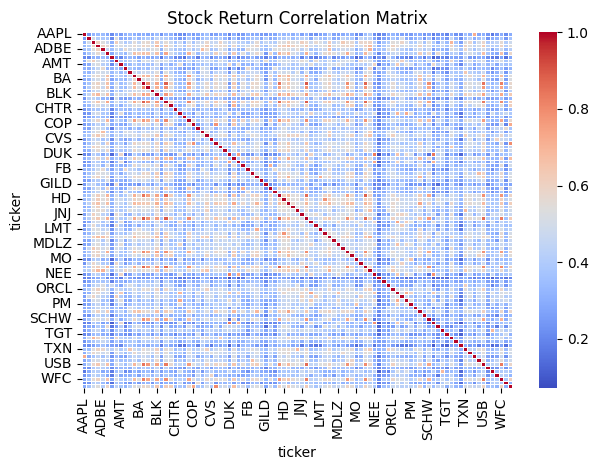

In [20]:
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Stock Return Correlation Matrix')
plt.tight_layout()
plt.show()

In [21]:
# Check if the correlation matrix is symmetric
is_symmetric = (correlation_matrix.values == correlation_matrix.T.values).all()

# Check if all elements are positive (> 0)
are_all_elements_positive = (correlation_matrix > 0).all().all()

# Print the results
print(f"The correlation matrix is symmetric: {is_symmetric}")
print(f"All elements in the correlation matrix are positive: {are_all_elements_positive}")

The correlation matrix is symmetric: True
All elements in the correlation matrix are positive: True


# 2. Hierarchical Clustering 

We will now perform hierarchical clustering on the stock returns correlation matrix to identify clusters of stocks with similar return patterns. To visualize the clusters, we will use a dendrogram.

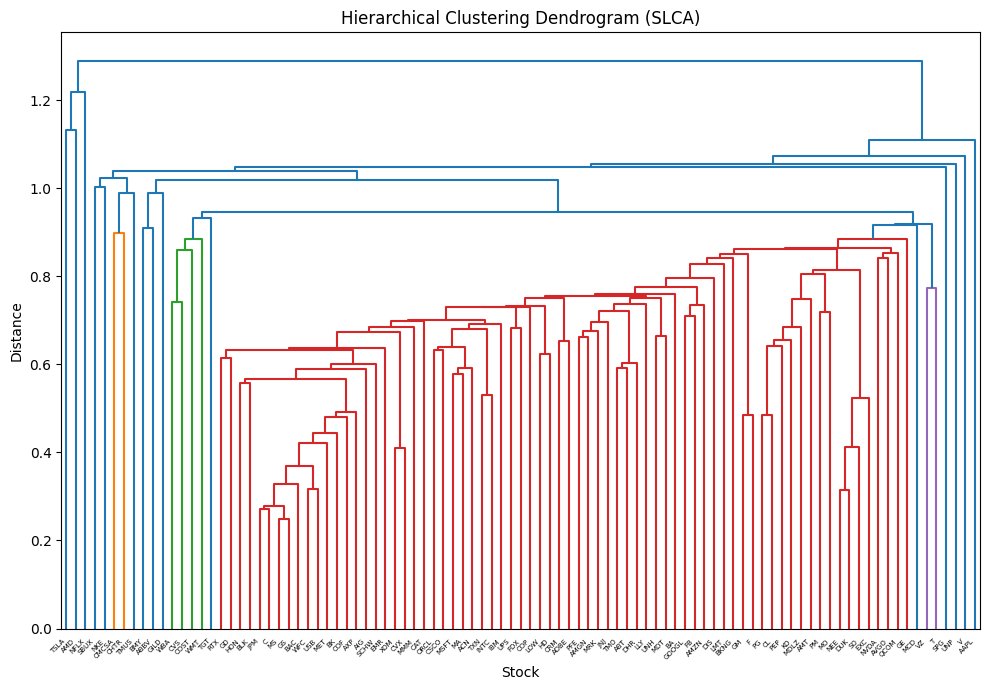

In [22]:
# Perform SLCA for hierarchical clustering

# The 'single' method refers to SLCA: 
# it computes the hierarchical clustering using the minimum pairwise distances between points in two clusters

linked = linkage(correlation_matrix, 'single')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, 
           color_threshold = None, #None #np.inf
           #above_threshold_color = 'black',
           orientation='top',
           labels=correlation_matrix.index,
           distance_sort='descending',
           show_leaf_counts=True)

plt.title('Hierarchical Clustering Dendrogram (SLCA)')
plt.xlabel('Stock')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

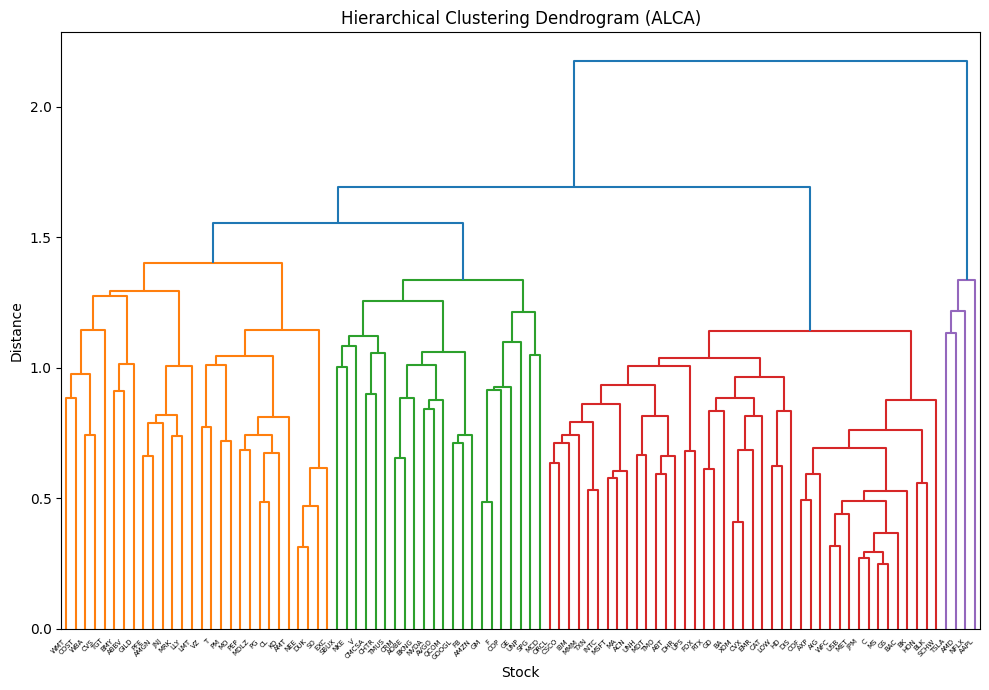

In [23]:
# Perform ALCA for hierarchical clustering
# The 'average' method refers to ALCA, using the average of the distances between all observations of the two sets
linked = linkage(correlation_matrix, 'average')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           labels=correlation_matrix.index,
           distance_sort='descending',
           show_leaf_counts=True)

plt.title('Hierarchical Clustering Dendrogram (ALCA)')
plt.xlabel('Stock')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Each leaf represents a stock ticker, and the vertical lines connect clusters based on their similarity in return patterns. The height of the vertical lines indicates the distance between clusters, with lower heights suggesting more similar clusters.

Regarding the order of tickers on the x-axis of the dendrogram, they are not directly related to the original order of tickers in your data or correlation matrix. Instead, the order is determined by the hierarchical clustering process itself. Each merge in the clustering process is based on the distance (or similarity) between clusters, with the algorithm deciding the order in which pairs of clusters are merged. This results in an ordering that reflects the structure discovered by the clustering process, with similar items placed next to each other as determined by the linkage criteria

A parameter named color_threshold controls the colour of the links —the horizontal and vertical lines that join the clusters— in the dendrogram generated by scipy.cluster.hierarchy.dendrogram. The threshold distance at which clusters will not be connected by the same colour is specified by this option. The goal is to visually discern between various clusters in the dendrogram according to their distances by using colour.

This is how it works:

- The color_threshold is by default set to 0.7 times the greatest separation between any two cluster merges.
- Depending on the linkage type (single, average, complete), a distance value is assigned to each merging (link) in the dendrogram.
- Two clusters are linked with the same colour if their separation is less than the colour threshold. This suggests that they are a part of the same larger group.
- The link is coloured differently if the distance is greater than the colour threshold, signifying the development of a new cluster group at that distance level.
- The color_threshold can be manually adjusted to alter the dendrogram's colouring and draw attention to various clustering levels. More colours will show up if you set it very low, suggesting sharper cluster distinctions. 

In [24]:
# Create a mapping of stock names to their sectors
ticker_to_sector = final_stock_returns.drop_duplicates('ticker').set_index('ticker')['sector'].to_dict()
#print(ticker_to_sector)

sector_to_color = {
    'Industrials': 'gainsboro',
    'Communication Services': 'rosybrown',
    'Health Care': 'coral',
    'Information Technology': 'royalblue',
    'Consumer Staples' : 'lightpink',
    'Consumer Discretionary': 'gold',
    'Financials' : 'yellowgreen',
    'Real Estate' : 'turquoise',
    'Energy' : 'slateblue',
    'Utilities': 'orchid'
}
ticker_colors = [sector_to_color[ticker_to_sector[ticker]] if ticker in ticker_to_sector else 'grey' for ticker in correlation_matrix.index]

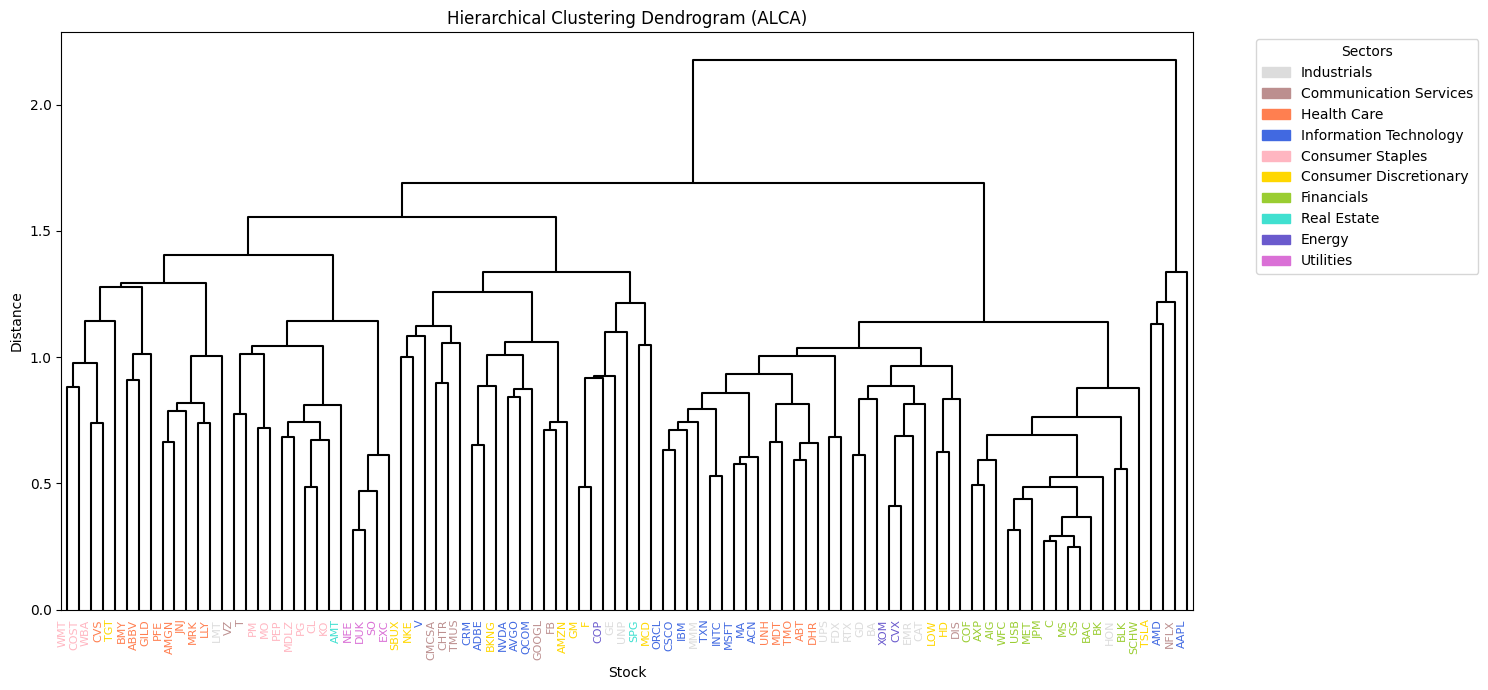

In [25]:
# Perform hierarchical clustering
linked = linkage(correlation_matrix, 'average') 

# Plot the dendrogram
plt.figure(figsize=(15, 7))
dendro = dendrogram(linked,
            orientation='top',
            color_threshold=np.inf,  # Disable automatic coloring based on threshold
            link_color_func=lambda k: 'black',  # Force all links to be black
           labels=correlation_matrix.index,
           distance_sort='descending',
           show_leaf_counts=True)

plt.title('Hierarchical Clustering Dendrogram (ALCA)')
plt.xlabel('Stock')
plt.ylabel('Distance')

# Set the color of x-axis tick labels
ax = plt.gca()  # Get the current Axes instance on the current figure
xticklabels = ax.get_xticklabels()
for i, label in enumerate(xticklabels):
    label.set_color(ticker_colors[dendro['leaves'][i]])  # dendro['leaves'] gives the order of leaf nodes

plt.xticks(rotation=90, ha="right", size=8)

# Create a custom legend
legend_handles = [Patch(color=color, label=sector) for sector, color in sector_to_color.items()]
plt.legend(handles=legend_handles, title="Sectors", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Convert the correlation matrix to a distance matrix
distance_matrix = 1 - correlation_matrix

# Create a graph from the distance matrix
G = nx.from_pandas_adjacency(distance_matrix, create_using=nx.Graph)

# 3. PCA

Principal Component Analysis (PCA) is a statistical technique used for dimensionality reduction, making it easier to visualize and interpret high-dimensional data by transforming it into a lower-dimensional space. It identifies the directions (or principal components) that maximize the variance in the data. These principal components are orthogonal to each other, and each successive component tries to capture the maximum variance remaining in the data after removing the variance captured by the previous components.

It is critical to study eigenvalues because they offer information about the relative importance of each principal component in the explanation of data variability. A higher eigenvalue signifies that a larger proportion of the overall variance in the dataset is captured by the corresponding principal component. We can determine how many principal components to keep for efficient data reduction while keeping as much of the original information as possible by looking at eigenvalues.

In [24]:
# Eigenvalue decomposition
eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)

In [25]:
# Sort eigenvalues and eigenvectors
ind = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[ind]
sorted_eigenvectors = eigenvectors[:,ind]

In [26]:
N = correlation_matrix.shape[0]  

# Print eigenvalues and explained variance
for i in range(N):
    print(f'Eigenvalue {i+1} = {sorted_eigenvalues[i]:.3f} ({sorted_eigenvalues[i]/N*100:.3f}% of variance explained)')

Eigenvalue 1 = 41.142 (43.307% of variance explained)
Eigenvalue 2 = 5.016 (5.280% of variance explained)
Eigenvalue 3 = 3.106 (3.270% of variance explained)
Eigenvalue 4 = 2.469 (2.599% of variance explained)
Eigenvalue 5 = 1.734 (1.826% of variance explained)
Eigenvalue 6 = 1.536 (1.617% of variance explained)
Eigenvalue 7 = 1.375 (1.448% of variance explained)
Eigenvalue 8 = 1.210 (1.274% of variance explained)
Eigenvalue 9 = 1.180 (1.242% of variance explained)
Eigenvalue 10 = 1.146 (1.207% of variance explained)
Eigenvalue 11 = 1.062 (1.118% of variance explained)
Eigenvalue 12 = 1.031 (1.085% of variance explained)
Eigenvalue 13 = 0.958 (1.008% of variance explained)
Eigenvalue 14 = 0.888 (0.934% of variance explained)
Eigenvalue 15 = 0.861 (0.906% of variance explained)
Eigenvalue 16 = 0.817 (0.860% of variance explained)
Eigenvalue 17 = 0.813 (0.856% of variance explained)
Eigenvalue 18 = 0.790 (0.832% of variance explained)
Eigenvalue 19 = 0.760 (0.800% of variance explained)


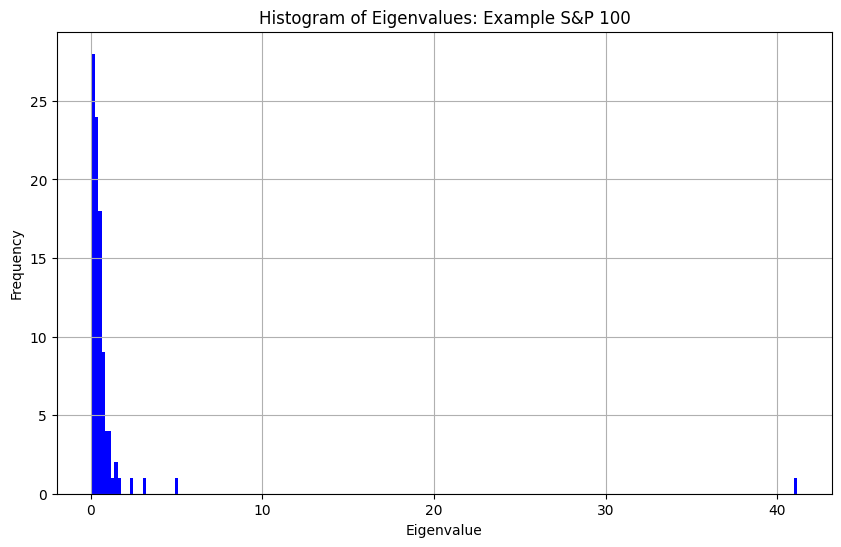

In [27]:
# Plotting the histogram of the eigenvalues
plt.figure(figsize=(10, 6))
plt.hist(eigenvalues, bins='auto', color='blue')
plt.title('Histogram of Eigenvalues: Example S&P 100')
plt.xlabel('Eigenvalue')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The presence of a large eigenvalue means that the corresponding PC account for a large fraction of the overall variance in the data.

One huge and isolated eigenvalue: as a first approximation we can assume the whole market to be explained by the first PC.

The 2nd eigenvalue is considerably smaller than 1st one but still significantly larger than other eigenvalues

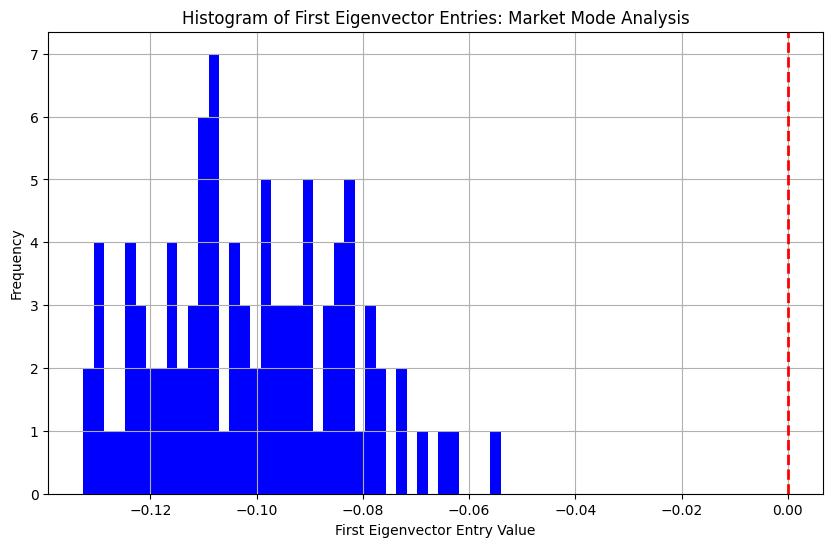

In [28]:
# Extract the first (largest) eigenvector
market_mode_vector = sorted_eigenvectors[:, 0]

# Plotting the histogram of the first eigenvector's entries
plt.figure(figsize=(10, 6))
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.hist(market_mode_vector, bins=40, color='blue')
plt.title('Histogram of First Eigenvector Entries: Market Mode Analysis')
plt.xlabel('First Eigenvector Entry Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

All components share the same sign: common factor driving all stocks.

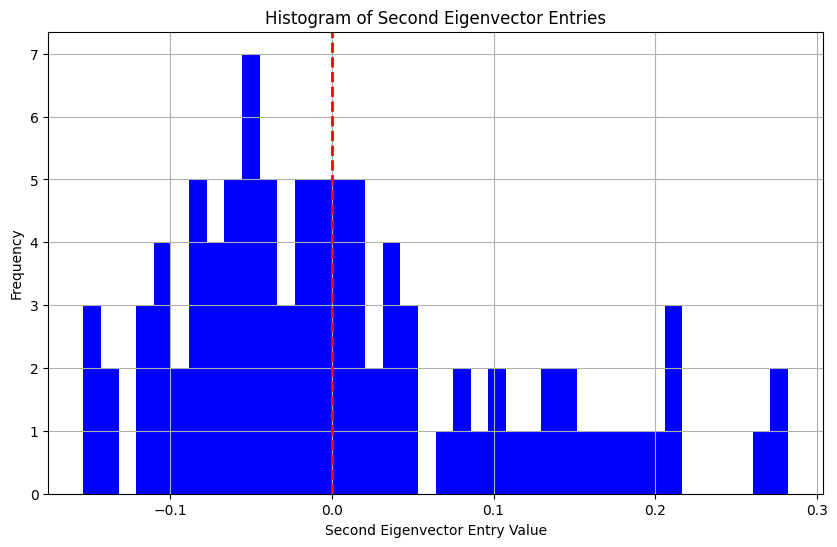

In [29]:
# Extract the second eigenvector
market_mode_vector = sorted_eigenvectors[:, 1]

# Plotting the histogram of the first eigenvector's entries
plt.figure(figsize=(10, 6))
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.hist(market_mode_vector, bins=40, color='blue')
plt.title('Histogram of Second Eigenvector Entries')
plt.xlabel('Second Eigenvector Entry Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Roughly 50-50 split between positive / negative components: 
Source of negative correlation between groups of stocks (typically belonging to different sectors)

There are several ways to figure out how many eigenvalues are needed to fully explain market dynamics. Although this aim is frequently served by the 'elbow' approach, it can also be overly basic, providing only one eigenvalue for complex market behaviours. A more complex approach uses the cumulative variance method, where the goal is to choose a selection of sorted eigenvalues that together explain 90% of the variance in the market. Because it takes into account the market's complexity and stays away from oversimplification by depending on many eigenvalues, this strategy is typically more successful.

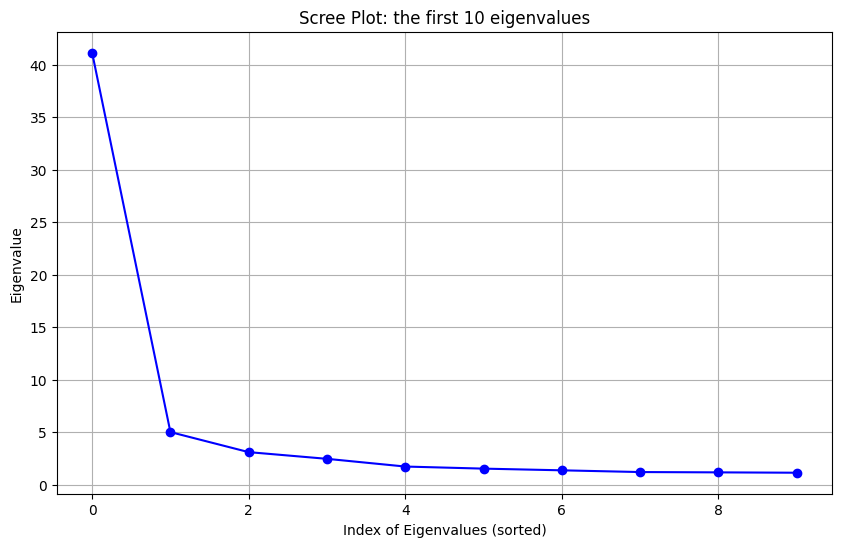

In [30]:
# Calculate the percentage of variance explained by each eigenvalue
variance_explained = sorted_eigenvalues / np.sum(sorted_eigenvalues) * 100

# Plotting the scree plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_eigenvalues[:10], marker='o', linestyle='-', color='b')
plt.title('Scree Plot: the first 10 eigenvalues')
plt.xlabel('Index of Eigenvalues (sorted)')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

In [31]:
# Calculate the percentage of variance explained by each sorted eigenvalue
variance_explained = sorted_eigenvalues / np.sum(sorted_eigenvalues)

# Calculate cumulative variance explained
cumulative_variance_explained = np.cumsum(variance_explained)

# Find the number of eigenvalues needed to explain at least 90% of the variance
num_eigenvalues_needed = np.where(cumulative_variance_explained >= 0.90)[0][0] + 1

print(f"Number of eigenvalues needed to explain 90% of cumulative variance: {num_eigenvalues_needed}")

Number of eigenvalues needed to explain 90% of cumulative variance: 53


In [32]:
data = np.array(correlation_matrix)

# Perform PCA
# n_components should be <= min(number of rows, number of columns) in your data
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)

# Extract the two principal components
principalDf = pd.DataFrame(data = principalComponents, columns = ['Principal Component 1', 'Principal Component 2'])

In [33]:
display(principalDf)

,Principal Component 1,Principal Component 2
0,1.225380,-0.672287
1,0.656594,-0.274153
2,-0.478232,0.383751
3,-0.806510,0.279750
4,-0.213098,-0.243884
...,...,...
90,0.953924,0.536408
91,0.762196,-0.007441
92,-1.148578,0.097010
93,1.120169,0.306626


Identifying Principal Components: 

The first principal component is the direction in which the returns of the stocks vary the most. It is a linear combination of the original stock returns that captures the maximum variance in the data. After extracting the first component, PCA looks for the next direction of maximum variance that is orthogonal (uncorrelated) to the first, which becomes the second principal component, and so on. Each subsequent component captures less variance than the previous one.

When it comes to stock returns, the first principal component usually represents the overall market trend, or moves that have an equivalent impact on the majority of stocks. This phenomenon is commonly known as the market effect. Variations orthogonal to the first major component may be captured by the second, which could reflect industry-specific patterns or other systemic variables that impact individual companies differently from the market as a whole.
Your dataset's complexity will be reduced from possibly hundreds of stocks (variables) to just two artificial variables (principal components) by concentrating on the first two elements. 

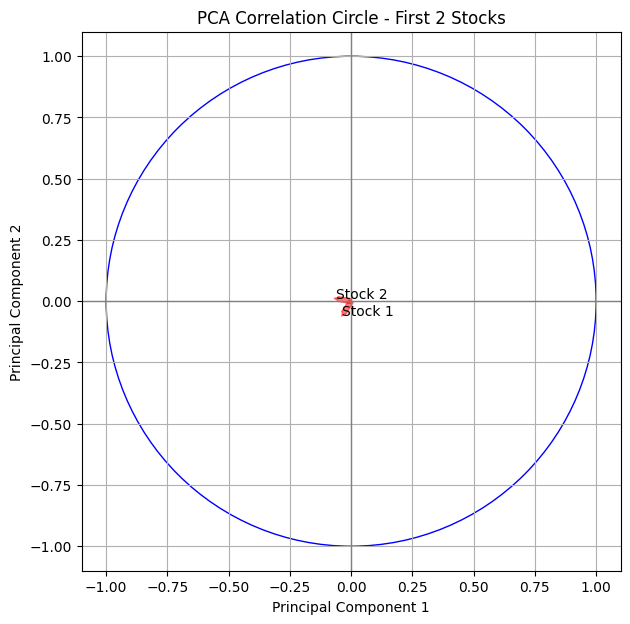

In [34]:
# Perform PCA
pca = PCA(n_components=2)
pca.fit(data)  

# Loadings (components) tell how much each feature contributes to each principal component
loadings = pca.components_.T  # Transpose to align with [variables x components] structure

# Now, let's visualize the first two stocks in the PCA correlation circle
plt.figure(figsize=(7, 7))
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_artist(circle)

# Plotting arrows for the first two stocks
for i in range(2):  # Change this to include more stocks if needed
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='r', alpha=0.5, width=0.02,
              head_width=0.01, length_includes_head=False)
    plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, f'Stock {i+1}', color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Correlation Circle - First 2 Stocks')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

When you create a PCA correlation circle with the first two principal components and plot the first three arrows (assuming these arrows represent the first three stocks or variables in your dataset), you are visualizing how these specific stocks (or variables) relate to the two main patterns (principal components) identified in your dataset of stock daily returns. Here's what this visualization tells you:

Each stock (or variable) is represented by an arrow in the correlation circle. The direction of the arrow indicates the degree of correlation between the stock's returns and the principal components, and the length of the arrow indicates the strength of that correlation.
Direction: An arrow indicates that the returns of the stock move in a manner consistent with the pattern that the major component captures if it points in the same general direction as the component. An arrow that closely lines with the first primary component, for example, indicates that the market trend that this component represents has a significant impact on the stock's returns.
Length: A longer arrow indicates that the two primary components account for a greater percentage of the variability in the stock. The stock's short arrow suggests that the stock's returns are less correlated with the main trends in the dataset, suggesting that other factors not captured by the first two components may be influencing its movements.

Component interpretation:
Stocks that are closely connected with the First Principal Component (PC1) may be heavily influenced by overall market fluctuations, as PC1 frequently captures the main market trend.
Second Principal Component (PC2): Generally represents deviations perpendicular to the first component, like trends unique to a given industry. Closely aligned stocks with PC2 may be impacted by factors other than the overall market trend.

Stocks’ Relationships: The angles between the arrows provide insights into the correlations between the stocks themselves. Arrows that point in similar directions indicate stocks that have similar return patterns, suggesting they might be affected by similar factors. Conversely, arrows that point in nearly opposite directions suggest stocks with returns that move in opposite ways relative to the main trends captured by the PCA.

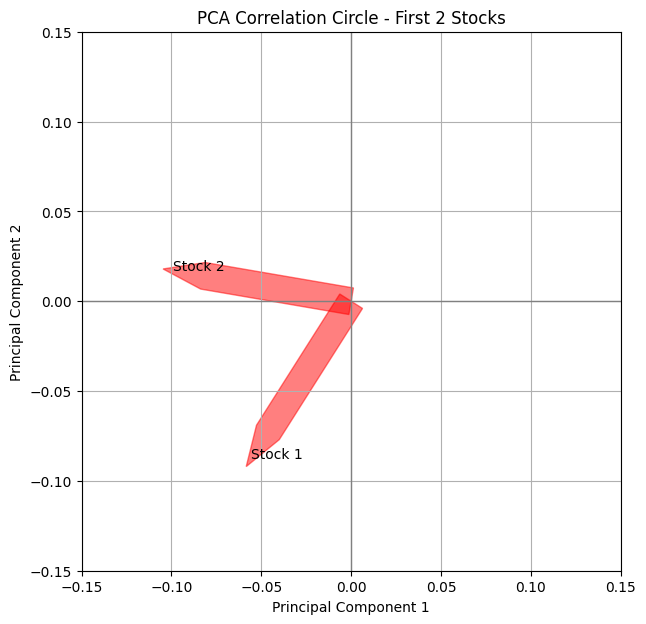

In [35]:
# Now, let's visualize the first two stocks in the PCA correlation circle with zoomed in view
plt.figure(figsize=(7, 7))
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_artist(circle)

# Increase the scale or adjust these limits to zoom in more
scale_factor = 1.5  # Adjust scale factor to zoom in or out

# Plotting arrows for the first two stocks with larger arrow size
for i in range(2):  # Change this to include more stocks if needed
    plt.arrow(0, 0, loadings[i, 0]*scale_factor, loadings[i, 1]*scale_factor, color='r', alpha=0.5, width=0.01*scale_factor,
              head_width=0.01*scale_factor, length_includes_head=False)
    plt.text(loadings[i, 0]*scale_factor*1.2, loadings[i, 1]*scale_factor*1.2, f'Stock {i+1}', color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Correlation Circle - First 2 Stocks')
# Adjust the limits here to "zoom in"
plt.xlim(-0.1*scale_factor, 0.1*scale_factor)
plt.ylim(-0.1*scale_factor, 0.1*scale_factor)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()